# Homework 9

## Q1: copulas

1. Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find** 
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it 
4. Describe how to use this to create arbitrary multivariate GLM regressions

## Answer to Q1

In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Import Dataset

This non-normally distributed dataset was sourced from Kaggle: https://www.kaggle.com/datasets/sacramentotechnology/sleep-deprivation-and-cognitive-performance. In this dataset, we will focus on Sleep Hours, Emotional Regulation Score, and PVT Reaction Time. 

In [2]:
sleep_data = pd.read_csv('sleep_deprivation_dataset_detailed.csv')
sleep_data

,Participant_ID,Sleep_Hours,Sleep_Quality_Score,Daytime_Sleepiness,Stroop_Task_Reaction_Time,N_Back_Accuracy,Emotion_Regulation_Score,PVT_Reaction_Time,Age,Gender,BMI,Caffeine_Intake,Physical_Activity_Level,Stress_Level
0,P1,5.25,15,12,1.60,64.20,12,365.85,35,Female,30.53,2,1,33
1,P2,8.70,12,14,2.54,65.27,21,288.95,20,Male,27.28,3,8,37
2,P3,7.39,17,10,3.40,74.28,35,325.93,18,Male,30.00,1,2,32
3,P4,6.59,14,3,3.54,72.42,25,276.86,18,Male,34.47,5,0,23
4,P5,3.94,20,12,3.09,99.72,60,383.45,36,Male,29.70,3,4,14
5,P6,3.94,12,6,2.84,58.80,46,224.48,28,Male,32.23,3,6,29
6,P7,3.35,8,18,3.16,50.90,31,201.56,22,Male,32.74,4,5,16
7,P8,8.20,14,21,3.28,74.69,66,388.37,29,Male,32.25,1,0,4
8,P9,6.61,12,1,1.74,58.94,38,258.28,20,Female,25.24,3,4,28
9,P10,7.25,0,9,2.61,68.32,23,221.28,18,Male,21.78,3,4,3


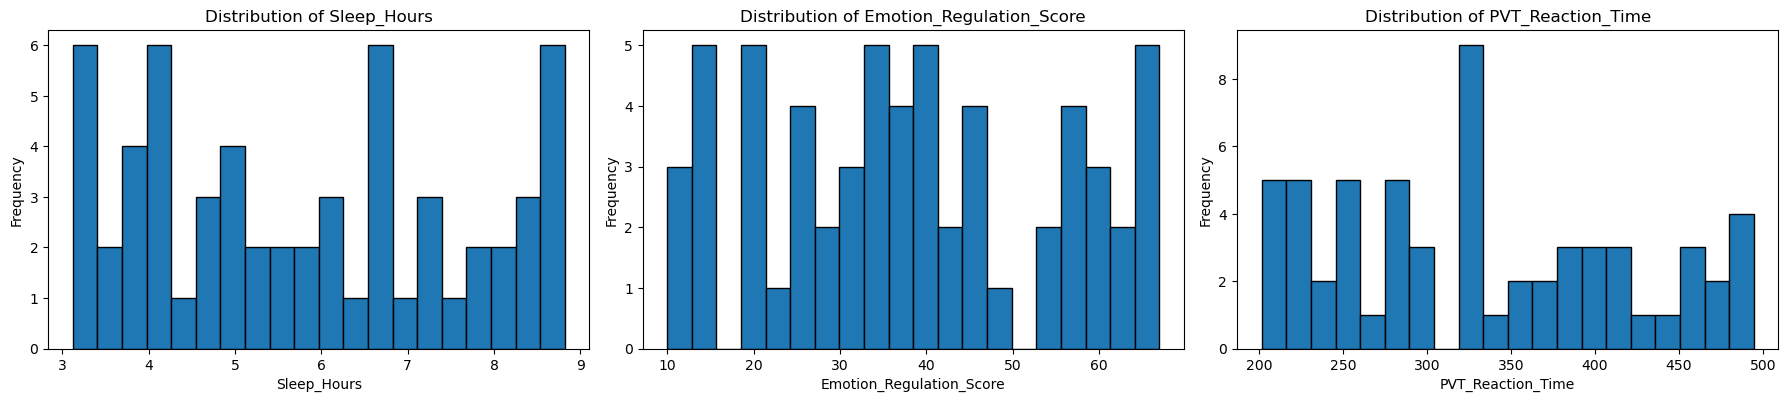

In [3]:
numeric_columns = [
    'Sleep_Hours', 'Emotion_Regulation_Score',
    'PVT_Reaction_Time'
]

plt.figure(figsize=(18, 15))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i)
    plt.hist(sleep_data[column], bins=20, edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

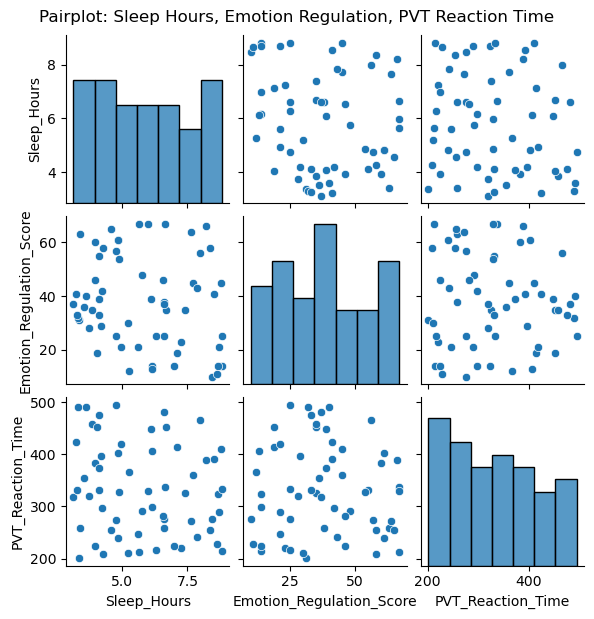

In [22]:
sns.pairplot(sleep_data[numeric_columns], height=2)
plt.suptitle("Pairplot: Sleep Hours, Emotion Regulation, PVT Reaction Time", y=1.02)
plt.show()

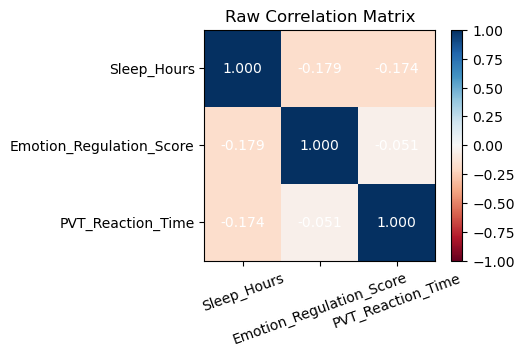

In [38]:
selected_vars = ["Sleep_Hours", "Emotion_Regulation_Score", "PVT_Reaction_Time"]

# plot correlation matrix
raw_corr = sleep_data[selected_vars].corr()

plt.figure(figsize=(4, 3))
ax = plt.gca()
cax = ax.imshow(raw_corr, cmap='RdBu', vmin=-1, vmax=1)

for i in range(3):
    for j in range(3):
        ax.text(j, i, f"{raw_corr.iloc[i, j]:.3f}", va='center', ha='center', color='white')

# Set tick labels
ax.set_xticks(range(3))
ax.set_xticklabels(selected_vars, rotation=20)
ax.set_yticks(range(3))
ax.set_yticklabels(selected_vars)

plt.title("Raw Correlation Matrix")
plt.colorbar(cax)

### Method 1: Copula (Subexercise Omitted as per Instructor's Comment on Piazza)

### Method 2: Two-pass Approach

#### Preparing Data for Modelling 

In [5]:
sleep = sleep_data['Sleep_Hours'].values
emotion = sleep_data['Emotion_Regulation_Score'].values
reaction = sleep_data['PVT_Reaction_Time'].values

In [7]:
# fit gamma distribution to number of hours slept
gamma_params = stats.gamma.fit(sleep, floc=0)
u_sleep = stats.gamma.cdf(sleep, *gamma_params)

# fit normal distribution to emotional regulation
norm_params = stats.norm.fit(emotion)
u_emotion = stats.norm.cdf(emotion, *norm_params)

# fit lognormal distribution to reaction time
lognorm_params = stats.lognorm.fit(reaction, floc=0)
u_reaction = stats.lognorm.cdf(reaction, *lognorm_params)

# gaussian copula
from scipy.stats import norm
z_sleep = norm.ppf(u_sleep)
z_emotion = norm.ppf(u_emotion)
z_reaction = norm.ppf(u_reaction)

Z = np.column_stack([z_sleep, z_emotion, z_reaction])

#### Using PyMC to Model

In [9]:
with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0),
                                   compute_corr=True)

    mvn = pm.MvNormal("copula_obs", mu=np.zeros(3), chol=L, observed=Z)

    idata4 = pm.sample(1000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


#### Visualizations and Diagnostics

array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>]],
      dtype=object)

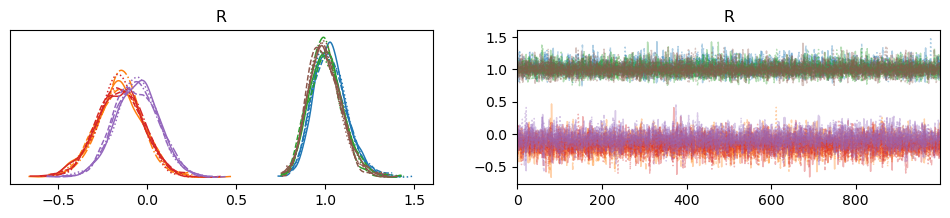

In [16]:
az.plot_trace(idata4, var_names=["R"])

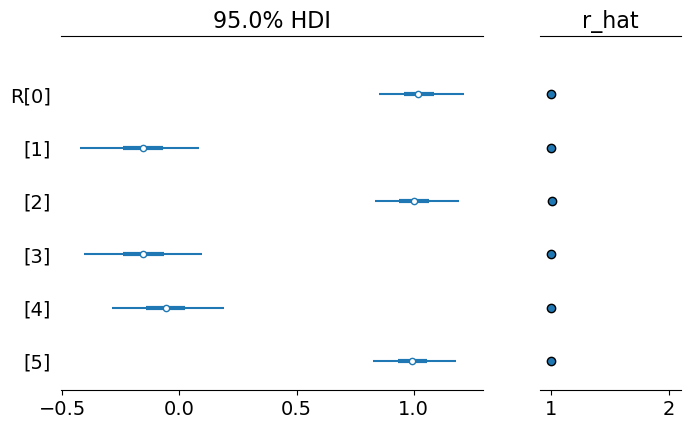

In [17]:
az.plot_forest(idata4, var_names=["R"], 
               combined=True, hdi_prob=0.95, r_hat=True);

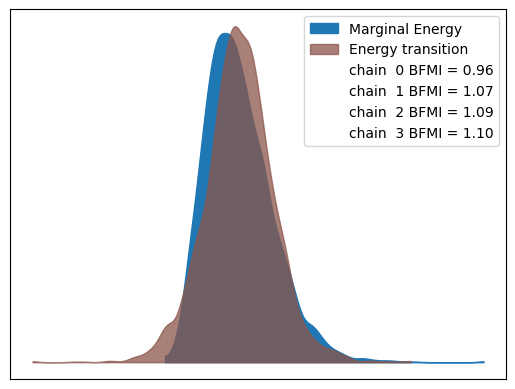

In [18]:
az.plot_energy(idata4);

#### Correlation Matrices Visualized

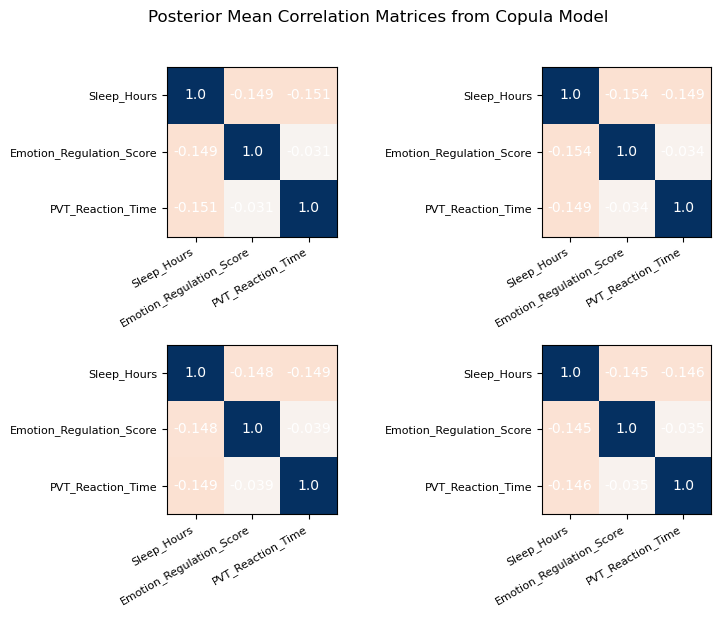

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

labels = ["Sleep_Hours", "Emotion_Regulation_Score", "PVT_Reaction_Time"]

matrices = list(idata4.posterior['R_corr'].values.mean(axis=1))[:4]

for idx, c in enumerate(matrices):
    row = idx // 2
    col = idx % 2
    ax[row, col].imshow(c, vmin=-1, vmax=1, cmap="RdBu")

    for k in range(3):
        for j in range(3):
            ax[row, col].text(j, k, s=str(round(c[k, j], 3)),
                              color='w', va='center', ha='center')

    ax[row, col].set_xticks(range(3))
    ax[row, col].set_xticklabels(labels, rotation=30, ha='right', fontsize=8)
    ax[row, col].set_yticks(range(3))
    ax[row, col].set_yticklabels(labels, fontsize=8)

plt.suptitle("Posterior Mean Correlation Matrices from Copula Model", y=1.02)
plt.tight_layout()
plt.show()

#### Bayesian Inference

The 94% credible intervals are given below:

In [12]:
az.summary(idata4, var_names=["R"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],1.027,0.095,0.857,1.205,0.001,0.002,5267.0,3508.0,1.0
R[1],-0.154,0.129,-0.395,0.089,0.002,0.002,4653.0,2771.0,1.0
R[2],1.005,0.094,0.832,1.171,0.001,0.002,5291.0,2991.0,1.0
R[3],-0.154,0.129,-0.395,0.085,0.002,0.002,5447.0,2814.0,1.0
R[4],-0.059,0.124,-0.285,0.174,0.002,0.002,5433.0,3046.0,1.0
R[5],0.999,0.092,0.824,1.163,0.001,0.002,5802.0,2967.0,1.0


### Explanation of Copula and its Implementations in Methods 1 and 2

A copula model allows us to model complicated distributions with correlations using a multivariate distribution, marginal distributions, and transformations. It separates the modelling of marginal distributions for each variable and the dependency structure between them. This is important if variables are not normally distributed, have different scales, or have other nonlinear relationships. To do this, marginal distributions are fitted for each variable, observations are transformed into a value from a uniform distribution using its CDF, and a copula function models the joint distribution of the uniform variables while a copula records the dependency structure.

There were 2 version that were used. In Method 1, the marginal distributions were estimated inside the model alongside the copula. As such, there were priors on both the marginal and copula parameters. The CDF was applied to get a uniform distribution and an inverse normal CDF was applied to get the standard normal. Their joint log-likelihood was evaluated under a multivariate normal with a correlation matrix. Through Method 1, one can also create simultaneous inferences on both marginals and the dependency structure. 

In contrast, Method 2 involved estimating the marginals before modelling the copula. The marginals were transformed to uniform with its CDF and had the inverse normal CDF applied to it. A PyMC model was only created to model their dependencies with a Gaussian copula. The model only provides inference for the correlation matrix and priors were only set on the copula parameters. Method 1 produced a full, unified model and was computationally slower. Method 2 required two steps and operated on the assumption of marginal parameters being completely known, but it was also faster to implement. Method 1 is theoretically better because it accounts for uncertainty in both the marginal distributions and the dependency structure. It can also provide better posterior predictive samples and joint posterior distributions since it is essentially 1 unified model.

### Creating Arbitrary Multivariate GLM Regressions

In a multivariate marginal GLM, there would be multiple response variables, where each response could follow a different distribution and depend on different predictors. The model should also capture the relationships between the response variables. This would involve fitting a GLM to each variable separately, transforming the GLM's response to a uniform value with its predictive CDF, and using a copula to model the joint distribution and capture the dependencies within the responses. With a two-pass approach, each variable has a GLM fitted separately before the predicted CDFs are inputted in a copula model. In a fully Bayesian copula model, each marginal GLM would be modeled inside the copula model, and they would have priors on regression parameters. The fully Bayesian model would fully explore the variability of the parameters and their uncertainty better than the two-pass approach. This model would sample all parameters jointly and the dependency structure would be updated based on the marginals' uncertainty.

## Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



## Answer to Q2

This dataset was sourced from Kaggle: https://www.kaggle.com/datasets/tarunkumar1912/fish-dataset1.
In this model, we will try to predict the weight and height of a fish based on its species, width, and the 3 lengths measured, which are its vertical length (Length1), diagonal length (Length2), and cross length (Length3). All length measurements are in centimetres. 

In [3]:
# import data
data = pd.read_csv("Fish_dataset.csv")
data

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [4]:
n_sample = 159 # used full dataset
fish_data_sample = data.sample(n=n_sample, random_state=42)

fish_data_sample = pd.get_dummies(fish_data_sample, columns=["Species"])

selected_predictors = ["Length1", "Length2", "Length3", "Width"] + list(fish_data_sample.filter(like="Species_").columns)
X_sample = fish_data_sample[selected_predictors].values
Y_sample = fish_data_sample[["Weight", "Height"]].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_sample)

scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y_sample)

# new dataset dimensions
n, p = X_scaled.shape  
m = Y_scaled.shape[1] 

### Spike and Slab

#### Using PyMC to Model

In [5]:
with pm.Model() as spike_and_slab:
    
    n, p = X_scaled.shape
    m = Y_scaled.shape[1]
    
    p_incl = pm.Beta('p_incl', alpha=1, beta=1)
    
    spike = pm.Bernoulli('spike', p=p_incl, shape=(p, m))
    slab = pm.Normal('slab', mu=0, sigma=100, shape=(p, m))
    beta = pm.Deterministic('beta', spike * slab) 
    
    intercept = pm.Normal('intercept', mu=0, sigma=10, shape=m)
    
    mu = pm.math.dot(X_scaled, beta) + intercept
    
    sigma_y = pm.Exponential('sigma_y', lam=1, shape=m)
    
    y = pm.Normal('y', mu=mu, sigma=sigma_y, observed=Y_scaled)
    
    idata = pm.sample(1000, tune=2000, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_incl, slab, intercept, sigma_y]
>BinaryGibbsMetropolis: [spike]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 119 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1642 divergences after tuning. Increase `target_accept` or reparameterize.


#### Diagnostics

/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Y

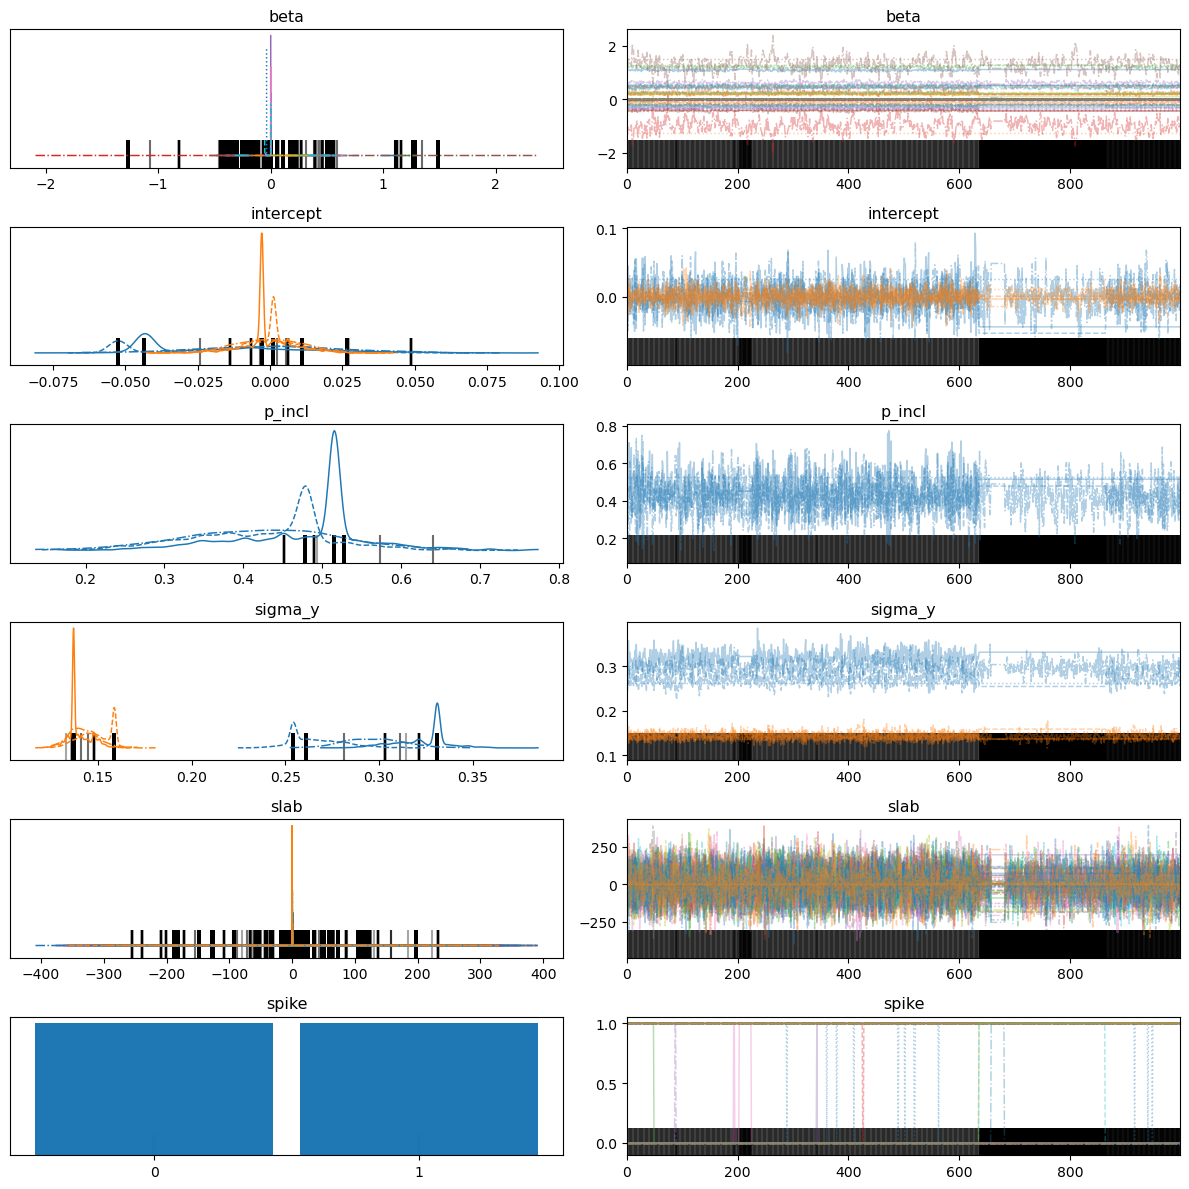

In [6]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


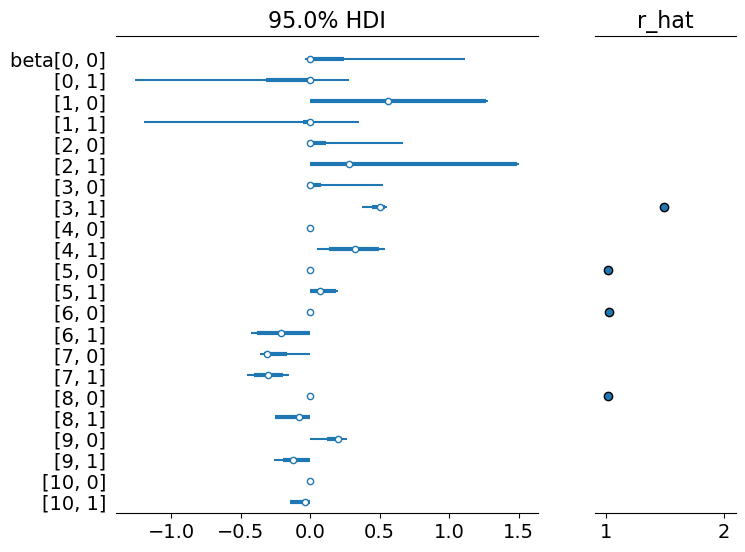

In [7]:
az.plot_forest(idata, var_names=["beta"], 
               combined=True, hdi_prob=0.95, r_hat=True);

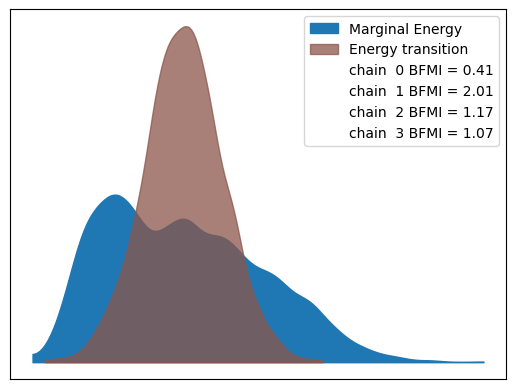

In [8]:
az.plot_energy(idata);

#### Results of Variable Selection

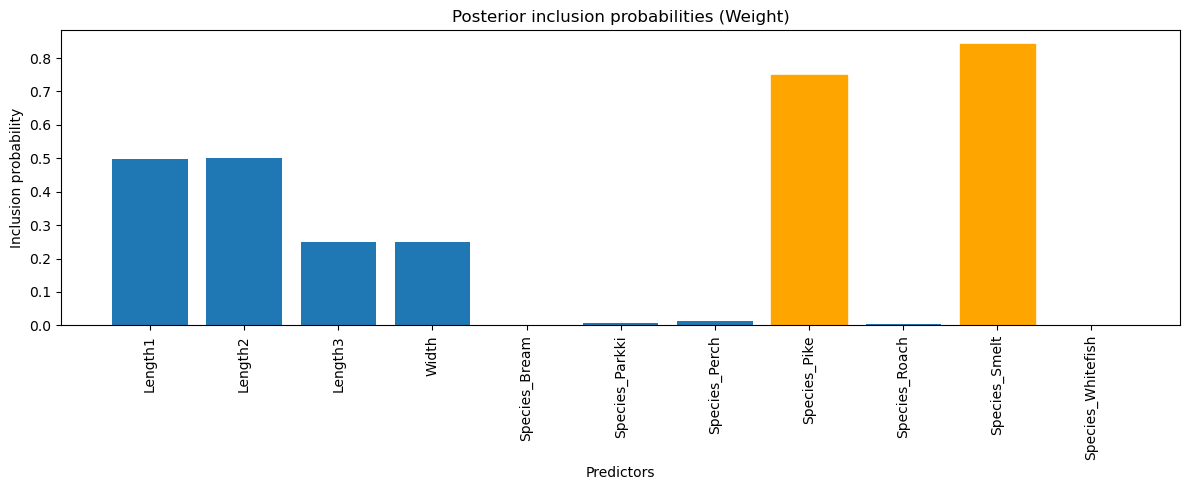

In [11]:
inclusion_probs = idata.posterior['spike'].mean(dim=('chain', 'draw')).values

# select threshold
threshold = 0.5  
important_indices = inclusion_probs[:, 0] > threshold
important_variables = [name for i, name in enumerate(selected_predictors) if important_indices[i]]

plt.figure(figsize=(12, 5))
bars = plt.bar(range(len(inclusion_probs[:, 0])), inclusion_probs[:, 0])
plt.title("Posterior inclusion probabilities (Weight)")
plt.xlabel("Predictors")
plt.ylabel("Inclusion probability")

plt.xticks(range(len(selected_predictors)), selected_predictors, rotation=90)

# highlight important predictors
for i, bar in enumerate(bars):
    if inclusion_probs[i, 0] > threshold:
        bar.set_color('orange')

plt.tight_layout()
plt.show()


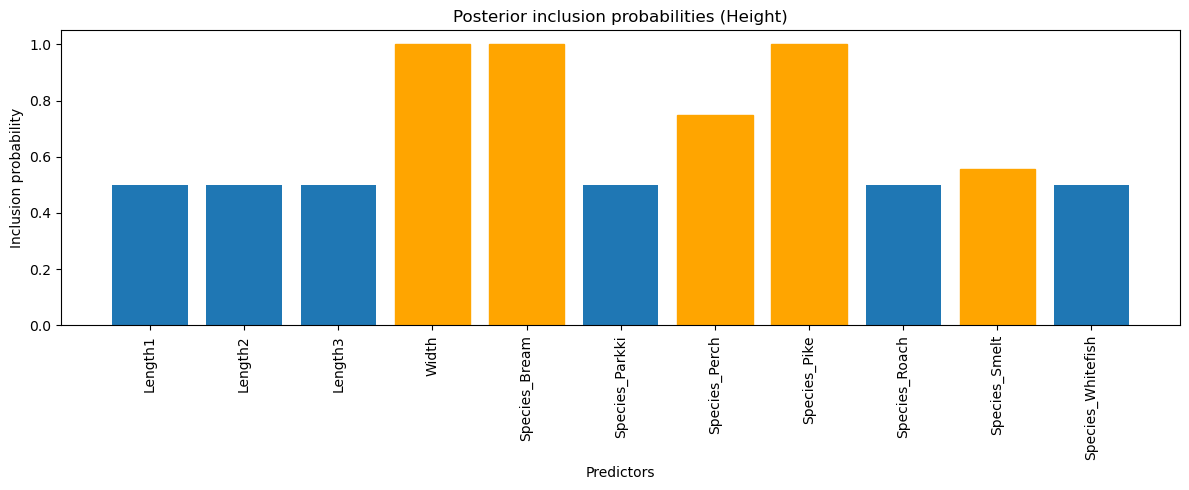

In [15]:
important_indices = inclusion_probs[:, 1] > threshold
important_variables = [name for i, name in enumerate(selected_predictors) if important_indices[i]]

plt.figure(figsize=(12, 5))
bars = plt.bar(range(len(inclusion_probs[:, 1])), inclusion_probs[:, 1])
plt.title("Posterior inclusion probabilities (Height)")
plt.xlabel("Predictors")
plt.ylabel("Inclusion probability")
plt.xticks(range(len(selected_predictors)), selected_predictors, rotation=90)

for i, bar in enumerate(bars):
    if inclusion_probs[i, 1] > threshold:
        bar.set_color('orange')

plt.tight_layout()
plt.show()

#### Post Predictive Sampling

Sampling: [y]


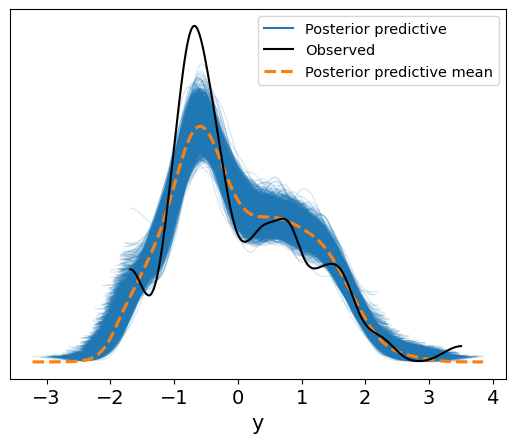

In [10]:
with spike_and_slab:
    ppc = pm.sample_posterior_predictive(idata, random_seed=42)

az.plot_ppc(ppc)
plt.show()

#### Bayesian Inference

The 94% credible intervals are given below:

In [9]:
az.summary(idata, var_names=['beta'], round_to=5)

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.26497,0.48061,-0.03714,1.11201,0.23926,0.13818,4.34070,4.09012,3.85076
"beta[0, 1]",-0.25727,0.58939,-1.26357,0.26745,0.29332,0.16525,4.28681,4.03226,9.53131
"beta[1, 0]",0.62025,0.62092,0.00000,1.26570,0.30906,0.00873,4.82123,4.03226,2.73982
"beta[1, 1]",-0.19137,0.48215,-1.17814,0.32910,0.23229,0.13910,4.57508,26.26240,3.44071
"beta[2, 0]",0.15560,0.27076,-0.00000,0.66050,0.13428,0.07837,4.53023,4.03226,3.15549
"beta[2, 1]",0.69513,0.71006,0.00000,1.48662,0.34818,0.02250,5.07134,4.03226,2.28569
"beta[3, 0]",0.11875,0.20752,0.00000,0.51587,0.10252,0.06037,4.55416,4.03226,3.15517
"beta[3, 1]",0.48647,0.05360,0.37847,0.54880,0.01960,0.00404,7.72921,62.50933,1.46775
"beta[4, 0]",0.00000,0.00000,-0.00000,-0.00000,0.00000,NaN,4000.00000,4000.00000,NaN
"beta[4, 1]",0.30939,0.18445,0.05206,0.53620,0.09138,0.03265,4.38250,4.03226,3.59072


### Analogous Inference with Diffuse Normal Priors (Minimal L2 Style Regularization on Likelihood)

In [15]:
with pm.Model() as diff_norm:
    n, p = X_scaled.shape
    m = Y_scaled.shape[1]

    intercept = pm.Normal('intercept', mu=0, sigma=10000, shape=m)
    betas = pm.Normal('betas', mu=0, sigma=100, shape=(p, m))
    sigma = pm.HalfNormal('sigma', sigma=100, shape=m)

    mu = pm.math.dot(X_scaled, betas) + intercept

    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=Y_scaled)

    idata2 = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 224 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


#### Diagnostics

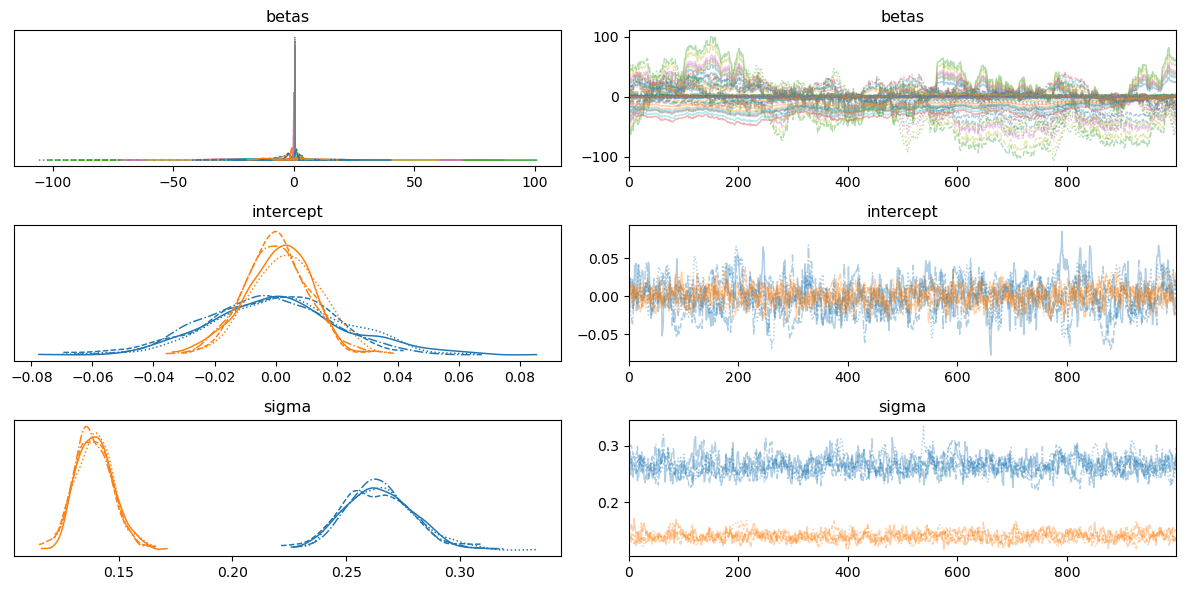

In [18]:
az.plot_trace(idata2)
plt.tight_layout()
plt.show()

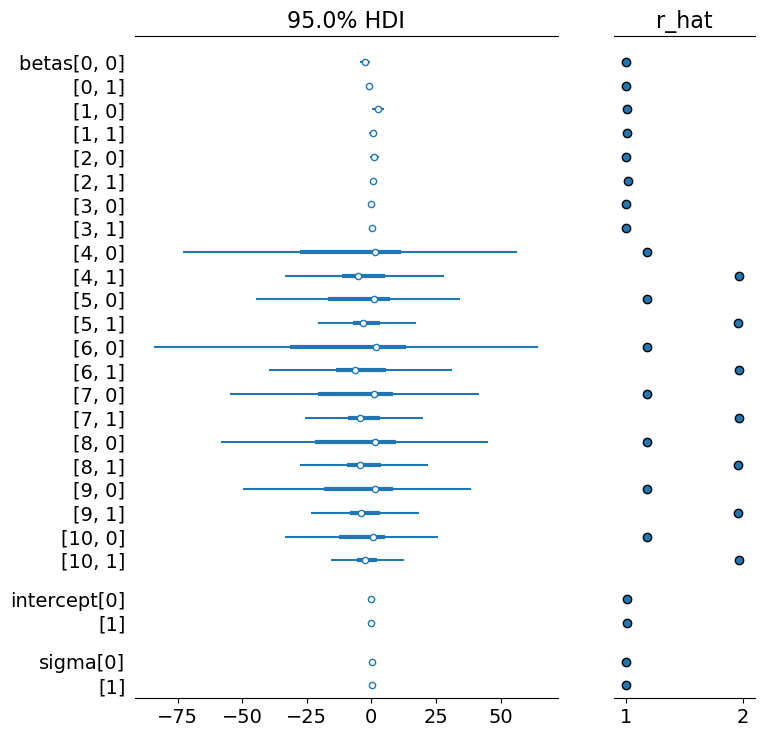

In [19]:
az.plot_forest(idata2, 
               combined=True, hdi_prob=0.95, r_hat=True);

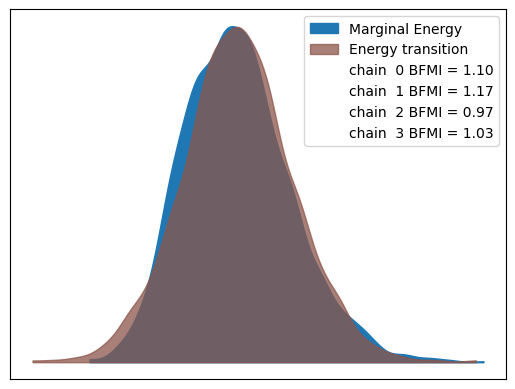

In [20]:
az.plot_energy(idata2);

#### Post Predictive Sampling

Sampling: [y]


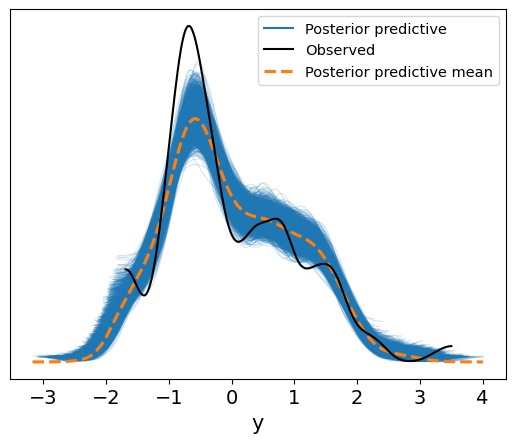

In [21]:
with diff_norm:
    ppc2 = pm.sample_posterior_predictive(idata2, random_seed=42)

az.plot_ppc(ppc2)
plt.show()

#### Bayesian Inference

The 94% credible intervals are given below:

In [24]:
az.summary(idata2, var_names='betas', round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-2.39197,0.99966,-4.47768,-0.61559,0.08529,0.05002,142.34353,165.65070,1.02018
"betas[0, 1]",-0.73940,0.52801,-1.72641,0.19197,0.04521,0.01629,129.86645,457.49719,1.03952
"betas[1, 0]",2.46542,1.18669,0.36498,4.86109,0.09106,0.05279,167.00293,297.73701,1.02991
"betas[1, 1]",0.43635,0.69736,-0.92617,1.71753,0.05446,0.02067,165.04385,430.34490,1.03024
"betas[2, 0]",1.16151,0.89349,-0.59116,2.76261,0.06239,0.02882,205.99615,483.79202,1.02118
"betas[2, 1]",0.60895,0.49830,-0.27583,1.57020,0.02709,0.01159,338.26252,947.83252,1.01471
"betas[3, 0]",0.01623,0.08982,-0.14303,0.19384,0.00555,0.00237,262.85743,643.96350,1.00566
"betas[3, 1]",0.42010,0.04782,0.33128,0.50951,0.00265,0.00116,325.46796,699.48651,1.00746
"betas[4, 0]",-5.90094,32.80109,-72.68130,52.12958,11.54826,5.45356,8.97579,20.63530,1.65893
"betas[4, 1]",-3.87236,15.98187,-33.47846,26.72379,7.11212,3.90575,5.17319,18.22300,2.15694


### Comparison and Discussion

In this model, the outcome variables were weight and height. The predictors were its species, width, and the 3 lengths measured, which are its vertical length (Length1), diagonal length (Length2), and cross length (Length3). The full dataset was used. There were several differences between the models used. The spike-and-slab model included features like variable selection, strong regularization, and figures such as inclusion probabilities showed the importance of each predictor for the outcome variables. To differentiate the most important predictors, an inclusion probability threshold of 0.5 was enforced. Notably, when predicting weight, the most important predictors were whether a fish belonged to the pike or smelt species, while predictors like whether a fish was a whitefish were unimportant and dropped entirely. For height, the most relevant predictors were a fish's width and whether it belong to any one of the following species: bream, perch, pike, roach, or smelt.

In the second model with diffuse normal priors and L2-style regularization, no variable selection was provided so all predictors are included, there was weak regularization, and it is more difficult to tell which coefficients matter more. While post predictive sampling in both models yielded similar results and capture the general shape of the observed distribution, there were several differences that were observed. For example, trace plots in the spike-and-slab model were much more chaotic due to predictors being excluded/included across MCMC samples. The energy plot also looked more problematic compared to the second model's, perhaps due to the spike-and-slab model itself. The forest plots's HDI intervals and credible intervals are much larger in the second model's, so there is more uncertainty about the predictors themselves. In contrast, the first model's HDI intervals and inferences are narrower, and some predictors are 0 entirely. There is more certainty as to the contribution of each predictor.

## Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations 

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



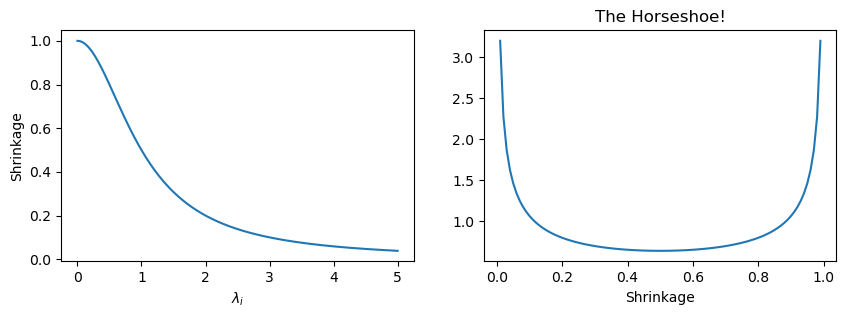

In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$") 
# change of variables: 
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage, 
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) * 
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

## Answer to Q3

The same dataset from Question 2 will be used. Again, we will try to predict the height and weight of a fish given its other predictors: species, length 1, length 2, length 3, and width. 

In [10]:
data

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


### Spike and Slab

Provided in Question 2

### Horseshoe

In [18]:
with pm.Model() as horseshoe:
    n, p = X_scaled.shape
    m = Y_scaled.shape[1]
    
    tau_0 = 1.0
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=m)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(p, m))
    # total shrinkage
    sigma_beta = pm.Deterministic('sigma_beta', tau * lambdas) 
    betas = pm.Normal('betas', mu=0, sigma=sigma_beta, shape=(p, m))

    intercept = pm.Normal('intercept', mu=0, sigma=10, shape=m)
    
    mu = pm.math.dot(X_scaled, betas) + intercept
    
    # noise
    sigma_y = pm.HalfNormal('sigma_y', sigma=5.0, shape = m)

    y = pm.Normal('y', mu=mu, sigma=sigma_y, observed=Y_scaled)

    idata3 = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambdas, betas, intercept, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 138 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.


#### Diagnostics

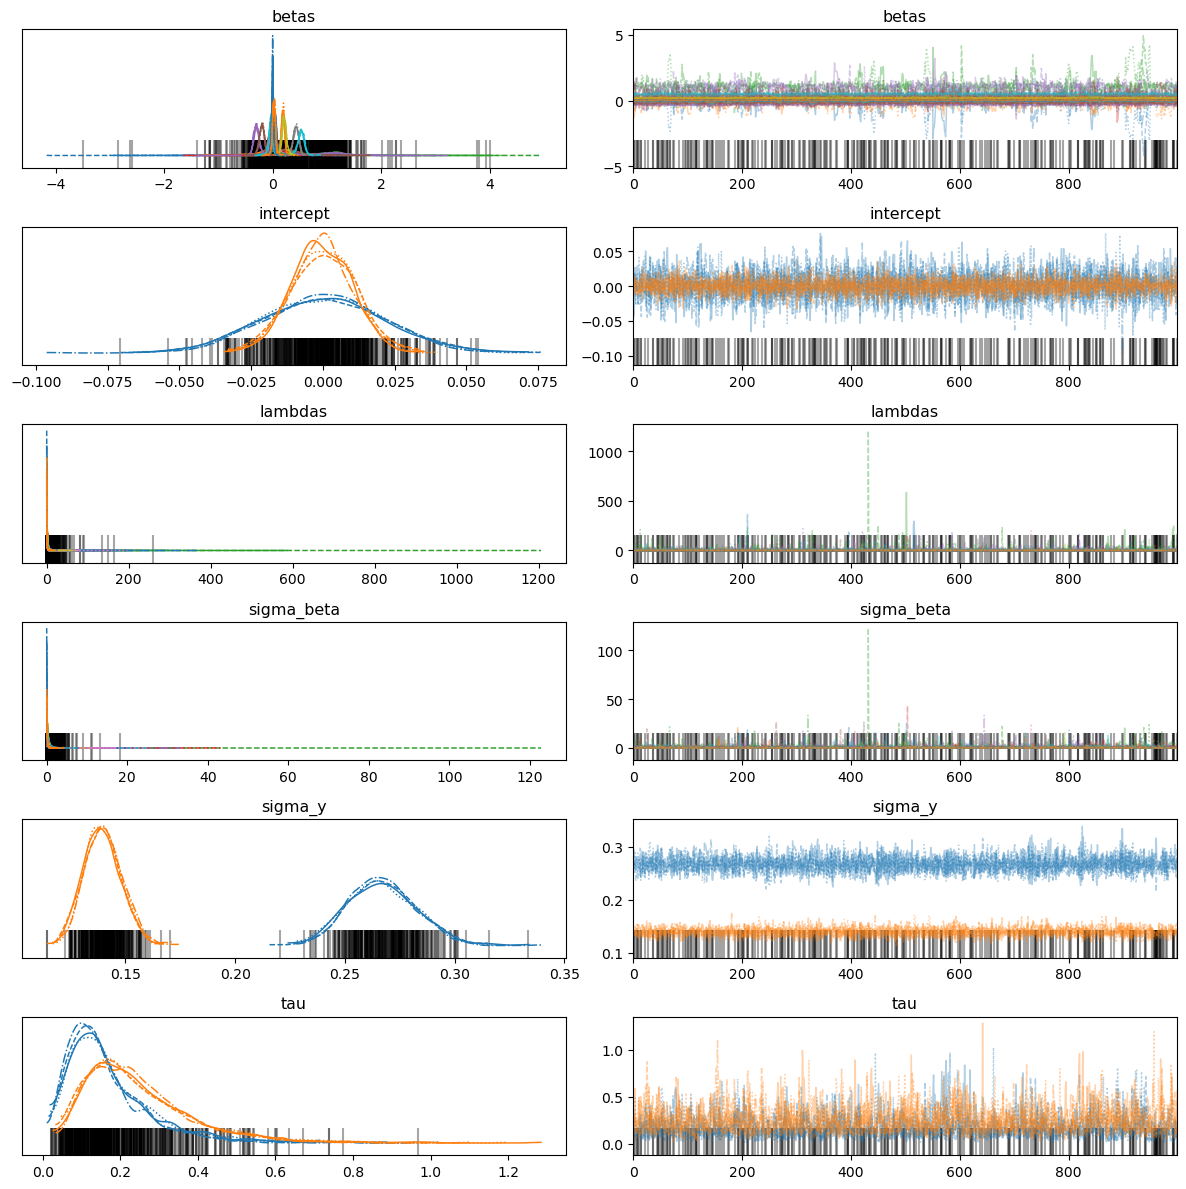

In [22]:
az.plot_trace(idata3)
plt.tight_layout()
plt.show()

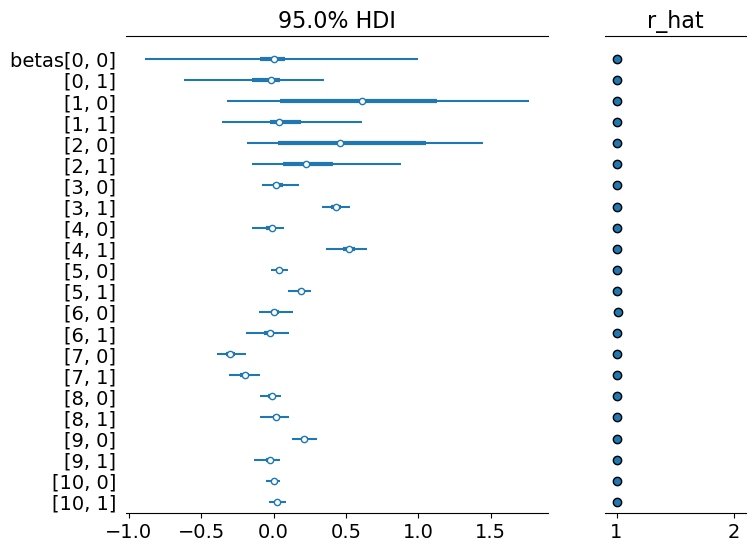

In [21]:
az.plot_forest(idata3, var_names=["betas"], 
               combined=True, hdi_prob=0.95, r_hat=True);

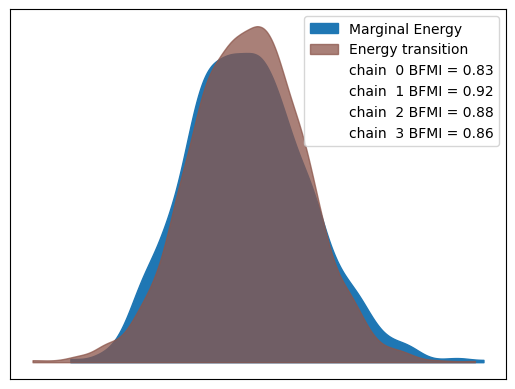

In [20]:
az.plot_energy(idata3);

#### Post Predictive Sampling

Sampling: [y]


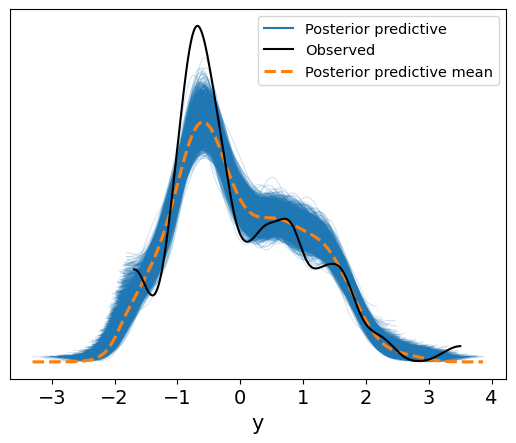

In [19]:
with horseshoe:
    ppc3 = pm.sample_posterior_predictive(idata3, random_seed=42)

az.plot_ppc(ppc3)
plt.show()

#### Bayesian Inference

The 94% credible intervals are given below:

In [14]:
az.summary(idata3, var_names=['betas', 'sigma_y'], round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",-0.12469,0.59069,-1.17706,1.08906,0.07063,0.13398,238.63731,48.19130,1.01980
"betas[0, 1]",-0.07356,0.23328,-0.54363,0.33299,0.00887,0.01330,1145.91671,583.61745,1.00843
"betas[1, 0]",0.82434,0.82140,-0.51146,2.09127,0.08930,0.12549,204.46388,54.27839,1.01736
"betas[1, 1]",0.06399,0.26056,-0.44510,0.53292,0.01510,0.01452,354.83632,67.77393,1.01499
"betas[2, 0]",0.47117,0.53537,-0.18674,1.44134,0.02303,0.00979,667.05806,1529.93357,1.00244
"betas[2, 1]",0.28438,0.28957,-0.15084,0.81554,0.01665,0.00952,383.26076,1114.00132,1.01153
"betas[3, 0]",0.02951,0.06687,-0.08407,0.17373,0.00168,0.00177,1777.12899,1805.25419,1.00328
"betas[3, 1]",0.43437,0.04826,0.34218,0.52520,0.00095,0.00092,2600.37282,2013.19331,1.00588
"betas[4, 0]",-0.02181,0.06076,-0.13851,0.07570,0.00280,0.00408,572.10101,685.54378,1.01022
"betas[4, 1]",0.51749,0.06772,0.38753,0.62867,0.00451,0.00500,271.22107,301.76943,1.02250


### Comparison and Discussion

When comparing the horseshoe and spike-and-slab models, several differences can be seen. For example, in the spike-and-slab model, predictors are either included or excluded. In the horseshoe model, shrinkage was softer. While there is global shrinkage imposed on all coefficients, more important ones can be preserved. Diagnostic plots in the horseshoe model yielded better results compared to the spike-and-slab model. For example, r-hat values of betas were all at 1, demonstrating convergence. This was not the case with the spike-and-slab model's forest plot. However, trends in the inferences and forest plots were similar across both models, where the first few beta coefficients had wide HDI intervals, suggesting higher uncertainty. Both models' inferences show us that betas [0,1], [0,0], and [1,0] have wide credible intervals with 0 included, suggesting they are not relevant when predicting weight. Betas like [3,1], [4,1], and [5,1] have narrower credible intervals not overlapping with 0, suggesting they are important in predicting height. Unlike inferences provided in spike-and-slab, where some betas like [6, 0] and [10, 0] were entirely 0, no coefficients were excluded in the horseshoe model's inferences, although the aforementioned beta coefficients' credible intervals included 0. Post predictive sampling yielded similar results in both models. Overall, the inferences provided by both models show similar trends.